### Structured data learning with Wide, Deep, and Cross networks

1. Wide and Deep Models
2. Deep and Cross Models


This example uses the **Covertype** dataset from the UCI Machine Learning Repository. The task is to predict forest cover type from cartographic variables. 

The dataset includes 506,011 instances with 12 input features: 10 numerical features and 2 categorical features. Each instance is categorized into 1 of 7 classes.

* **Wide**: Linear Classifier
* **Deep**: Deep Neural Net Classifier
* **Wide and Depp**: Combined Linear and Deep Classifier

Note: 'hidden_units' or 'dnn_hidden_units' arguments are the size of each layer. For example, [12, 20, 15] would create a network with the first layer of size 12, the second layer of size 20, and a third layer of size 15.



In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Download data using URL

In [ ]:
data_url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz")

database = pd.read_csv(data_url, header=None)

database.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
database.shape

(581012, 55)

In [ ]:
database[database.columns[:15]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,0
581008,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,0
581009,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,0
581010,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,0


The two categorical features in the dataset are binary-encoded. We will convert this dataset representation to the typical representation, where each categorical feature is represented as a single integer value.



In [ ]:
# CSV Headers were obtained from the document
CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

In [ ]:
soil_type_values = [f'soil_type_{idx+1}' for idx in range(40)]   # We have 40 diffenet types of soil in dataset
wilderness_area_values = [f'area_type_{idx+1}' for idx in range(4)]  # We have 4 diffenet types of wilderness area in dataset

soil_type = database.loc[:, 14:53].apply(lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)  # nonzero(): Return the indices of the elements that are non-zero.
wilderness_area = database.loc[:, 10:13].apply(lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)

In [ ]:
soil_type

0         soil_type_29
1         soil_type_29
2         soil_type_12
3         soil_type_30
4         soil_type_29
              ...     
581007     soil_type_2
581008     soil_type_2
581009     soil_type_2
581010     soil_type_2
581011     soil_type_2
Length: 581012, dtype: object

In [ ]:
wilderness_area

0         area_type_1
1         area_type_1
2         area_type_1
3         area_type_1
4         area_type_1
             ...     
581007    area_type_3
581008    area_type_3
581009    area_type_3
581010    area_type_3
581011    area_type_3
Length: 581012, dtype: object

### Combine and reconstruct dataset using separated groups



In [ ]:
data = pd.concat([database.loc[:, 0:9], wilderness_area, soil_type, database.loc[:, 54]], axis=1, ignore_index=True)   # axis=1 - column base concatenation
data.columns = CSV_HEADER    # Set column names as CSV_HEADERs

data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,5
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,5
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,2
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,2
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,area_type_3,soil_type_2,3
581008,2391,152,19,67,12,95,240,237,119,845,area_type_3,soil_type_2,3
581009,2386,159,17,60,7,90,236,241,130,854,area_type_3,soil_type_2,3
581010,2384,170,15,60,5,90,230,245,143,864,area_type_3,soil_type_2,3


In [ ]:
max(data["Cover_Type"])

7

In [ ]:
# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

max(data["Cover_Type"])

6

In [ ]:
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,4
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,4
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,1
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,1
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,4


In [ ]:
data.head().T

,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


### Split Data into Training and Test sets

In [ ]:
for _, group_data in data.groupby('Cover_Type'):
  print(len(group_data.index))
  print(np.random.rand(len(group_data.index)))

211840
[0.13952656 0.77906801 0.64359584 ... 0.61928672 0.82432484 0.74019138]
283301
[0.5565408  0.06952316 0.48509368 ... 0.35821262 0.08441268 0.91874857]
35754
[0.62368764 0.80318024 0.21826138 ... 0.66431201 0.48030016 0.18307478]
2747
[0.16616192 0.21466389 0.41591748 ... 0.9738804  0.36874872 0.25328884]
9493
[0.94264141 0.65688156 0.69977619 ... 0.60969228 0.94115218 0.00619834]
17367
[0.11517732 0.56553455 0.62434962 ... 0.23587406 0.29091703 0.38410984]
20510
[0.97854602 0.51903294 0.46369028 ... 0.52345134 0.14912225 0.68186293]


In [ ]:
TRAIN_TEST_SPLIT_RATIO = 0.85

train_splits = []
test_splits = []

# We split data into training and test sets with 0.85 ratio
for _, group_data in data.groupby('Cover_Type'):    # 7 Cover_Type with index names 0 to 6
  random_selection = np.random.rand(len(group_data.index)) <= TRAIN_TEST_SPLIT_RATIO
  train_splits.append(group_data[random_selection])
  test_splits.append(group_data[~random_selection])

''' 
reset_index(): Reset the index of the DataFrame, and use the default one instead.

>> df = pd.DataFrame([('bird', 389.0),
                   ('bird', 24.0),
                   ('mammal', 80.5),
                   ('mammal', np.nan)],
                  index=['falcon', 'parrot', 'lion', 'monkey'],
                  columns=('class', 'max_speed'))
>> df
         class  max_speed
falcon    bird      389.0
parrot    bird       24.0
lion    mammal       80.5
monkey  mammal        NaN


>> df.reset_index()
    index   class  max_speed
0  falcon    bird      389.0
1  parrot    bird       24.0
2    lion  mammal       80.5
3  monkey  mammal        NaN

>> df.reset_index(drop=True)
    class  max_speed
0    bird      389.0
1    bird       24.0
2  mammal       80.5
3  mammal        NaN
'''
train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)   # frac=1 - return all elements
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 494153
Test split size: 86859


### Save training and tes data in separate CSV files

In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [ ]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data['Soil_Type'].unique()),
    "Wilderness_Area": list(data['Wilderness_Area'].unique())
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in (NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME]) else ['NA'] for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

### Experiment Setup

In [ ]:
# This method will be used to get train and test data csv files
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):
  dataset = tf.data.experimental.make_csv_dataset(
      csv_file_path,
      batch_size=batch_size,
      column_names=CSV_HEADER,
      column_defaults=COLUMN_DEFAULTS,
      label_name=TARGET_FEATURE_NAME,
      num_epochs=1,
      header=True,
      shuffle=shuffle,
  )
  return dataset.cache()

In [ ]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]   # 2 layers with sizes 32

# Run this method after creating the model
def run_experiment(model):
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=[keras.metrics.SparseCategoricalAccuracy()]
                )
  # Shuffle for training dataset
  train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
  test_dataset = get_dataset_from_csv(test_data_file, batch_size)

  # Train the model
  print("Start training the model")
  history = model.fit(train_dataset, epochs=num_epochs)
  print("Model training finished")

  # Evaluate the model with dataset
  _, accuracy = model.evaluate(test_dataset, verbose=0)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test accuracy: {accuracy}%")

### Create model inputs

In [ ]:
# Create appropriate inputs for models
def create_model_inputs():
  inputs = {}

  for feature_name in FEATURE_NAMES:
    if feature_name in NUMERIC_FEATURE_NAMES:
      # Add Input layer to inputs dict for numeric features (tf.float32)
      inputs[feature_name] = layers.Input(
          name=feature_name, shape=(), dtype=tf.float32
      )
    else:
      # Add Input layer to inputs dict for categorical features (tf.string)
      inputs[feature_name] = layers.Input(
          name=feature_name, shape=(), dtype=tf.string
      )
  return inputs

### Encode Features

We create two representations of our input features: sparse and dense: 1. In the **sparse representation**, the **categorical features** are encoded with **one-hot encoding** using the **CategoryEncoding layer**. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the **dense representation**, the categorical features are **encoded** with **low-dimensional embeddings** using the **Embedding layer**. This representation helps the model to generalize well to unseen feature combinations.

In [ ]:
# A preprocessing layer which maps string features to integer indices
from tensorflow.keras.layers import StringLookup

def encode_inputs(inputs, use_embedding=False):
  encoded_features = []

  for feature_name in inputs:
    if feature_name in CATEGORICAL_FEATURE_NAMES:
      vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
      # Create a lookup to convert string values to an integer indices
      lookup = StringLookup(
          vocabulary=vocabulary,
          mask_token=None,
          num_oov_indices=0, # The number of out-of-vocabulary tokens to use. 
          # If this value is more than 1, OOV inputs are hashed to determine 
          # their OOV value. If this value is 0, OOV inputs will cause an error 
          #when calling the layer.
          output_mode='int' if use_embedding else 'binary',
      )

      if use_embedding:
        # Convert string input values to int indices
        encoded_feature = lookup(inputs[feature_name])
        embedding_dims = int(math.sqrt(len(vocabulary)))  # to decrease dimesion of the output
        # Create an embedding layer with the specified dimensions
        embedding = layers.Embedding(input_dim=len(vocabulary), output_dim=embedding_dims)
        # Convert the index values to embedding representations
        encoded_feature = embedding(encoded_feature)
      else:
        # Convert the string input values into a one-hot-encoding
        encoded_feature = lookup(tf.expand_dims(inputs[feature_name], axis=-1))
    # feature_name not in CATEGORICAL_FEATURE_NAMES
    else:
      # Use the numerical features as
      encoded_feature = tf.expand_dims(inputs[feature_name], axis=-1)
    
    encoded_features.append(encoded_feature)
  
  all_features = layers.concatenate(encoded_features)
  return all_features

### Create Baseline Model

In [ ]:
def create_baseline_model():
  inputs = create_model_inputs()
  features = encode_inputs(inputs)   # embeddings=False

  for units in hidden_units:    # [32, 32]
    features = layers.Dense(units)(features)
    features = layers.BatchNormalization()(features)
    features = layers.ReLU()(features)
    features = layers.Dropout(dropout_rate)(features)

  outputs = layers.Dense(units=NUM_CLASSES, activation='softmax')(features)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

### Plotting the Model Architecture

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


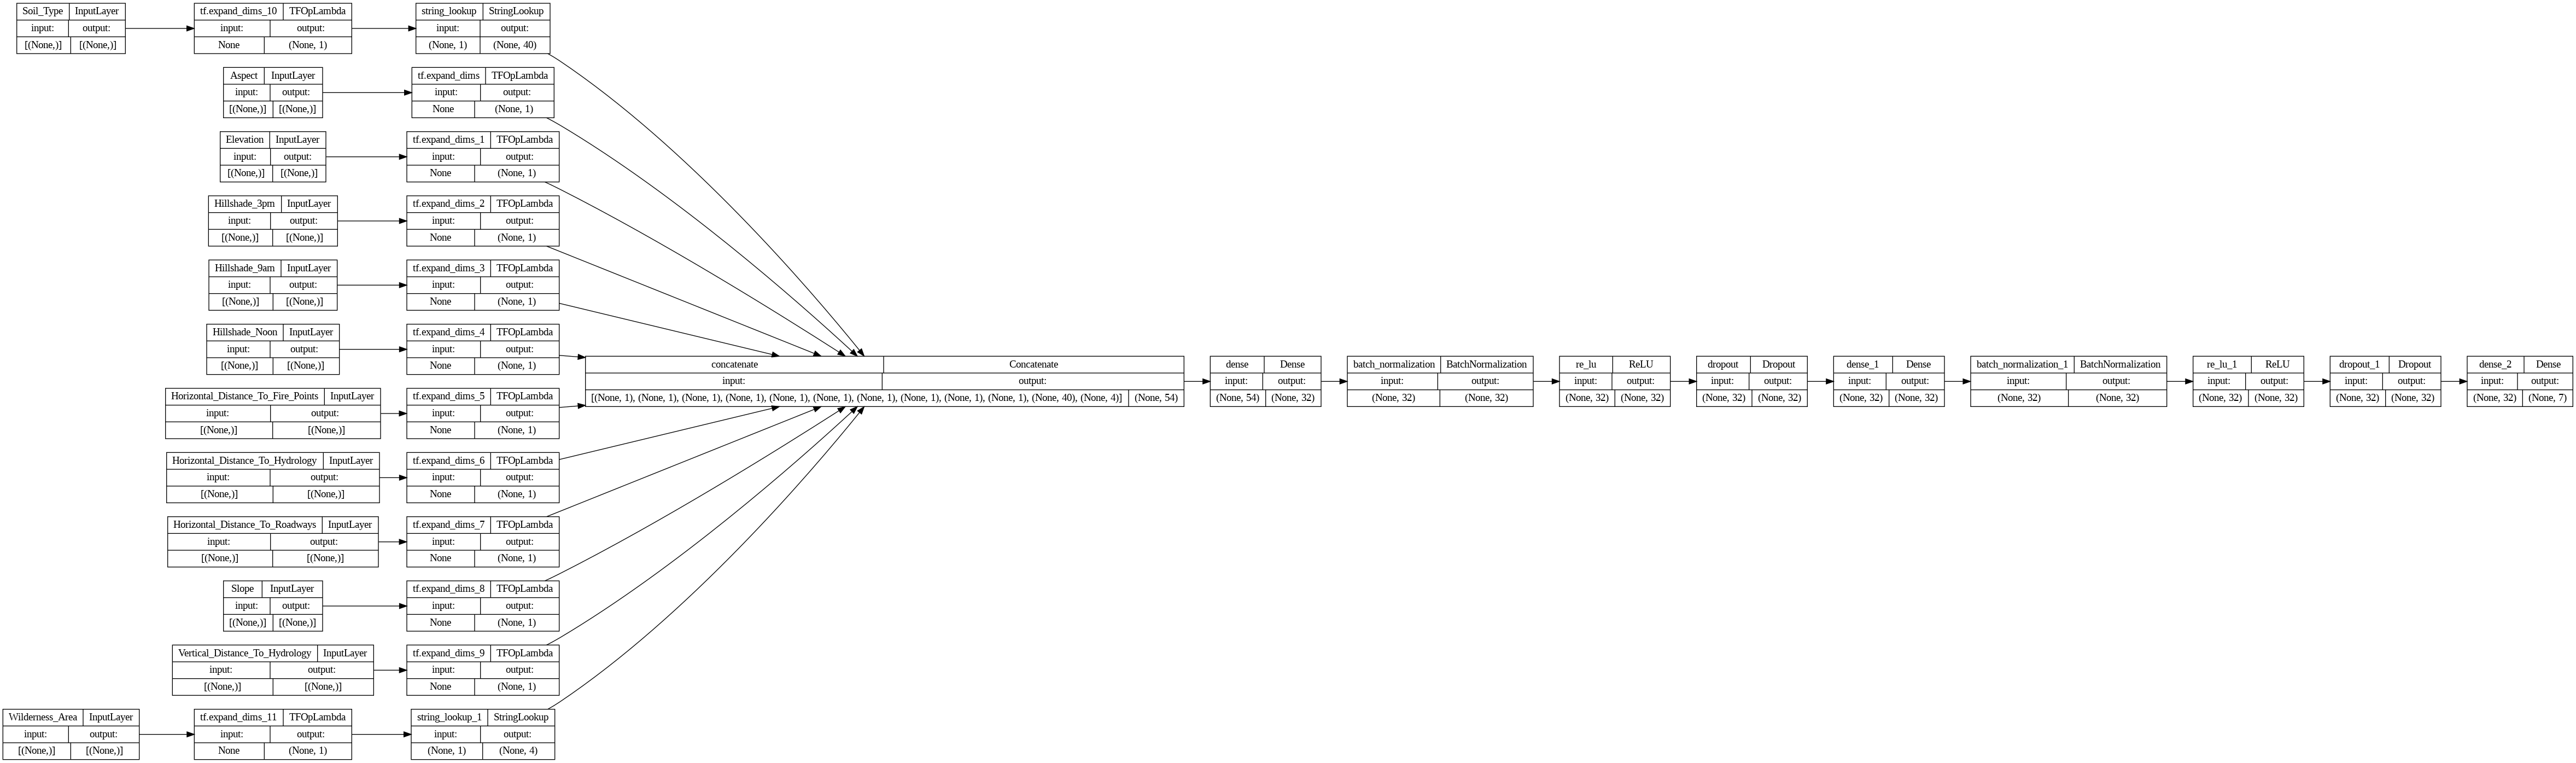

In [ ]:
baseline_model = create_baseline_model()

keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
'''
rankdir="TB": Top to bottom (default)
rankdir="BT": Bottom to top
rankdir="LR": Left to right
rankdir="RL": Right to left
'''

In [ ]:
run_experiment(baseline_model)

Start training the model
Epoch 1/50
1865/1865 [==============================] - 29s 14ms/step - loss: 0.7987 - sparse_categorical_accuracy: 0.6698
Epoch 2/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6738 - sparse_categorical_accuracy: 0.7117
Epoch 3/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.6483 - sparse_categorical_accuracy: 0.7203
Epoch 4/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.6253 - sparse_categorical_accuracy: 0.7304
Epoch 5/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.6095 - sparse_categorical_accuracy: 0.7375
Epoch 6/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.7413
Epoch 7/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.5923 - sparse_categorical_accuracy: 0.7449
Epoch 8/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.5862 - sparse_categorical_accuracy: 0.7473


The baseline linear model achieves ~76% test accuracy.

### Wide and Deep Model

The **wide part** of the model a **linear model**, while the deep part of the model is a multi-layer feed-forward network.

Use the **sparse** representation of the input features in the **wide part** of the model and the **dense** representation of the input features for the **deep part** of the model.

Every input features contributes to both parts of the model with different representations.

In [ ]:
def create_wide_and_deep_model():
  inputs = create_model_inputs()
  # Wide part of the model
  wide = encode_inputs(inputs)   # embedding=False
  wide = layers.BatchNormalization()(wide)

  # Deep part of the model
  deep = encode_inputs(inputs, use_embedding=True)
  for units in hidden_units:
    deep = layers.Dense(units)(deep)
    deep = layers.BatchNormalization()(deep)
    deep = layers.ReLU()(deep)
    deep = layers.Dropout(dropout_rate)(deep)

  merged = layers.concatenate([wide, deep])
  outputs = layers.Dense(units=NUM_CLASSES, activation='softmax')(merged)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

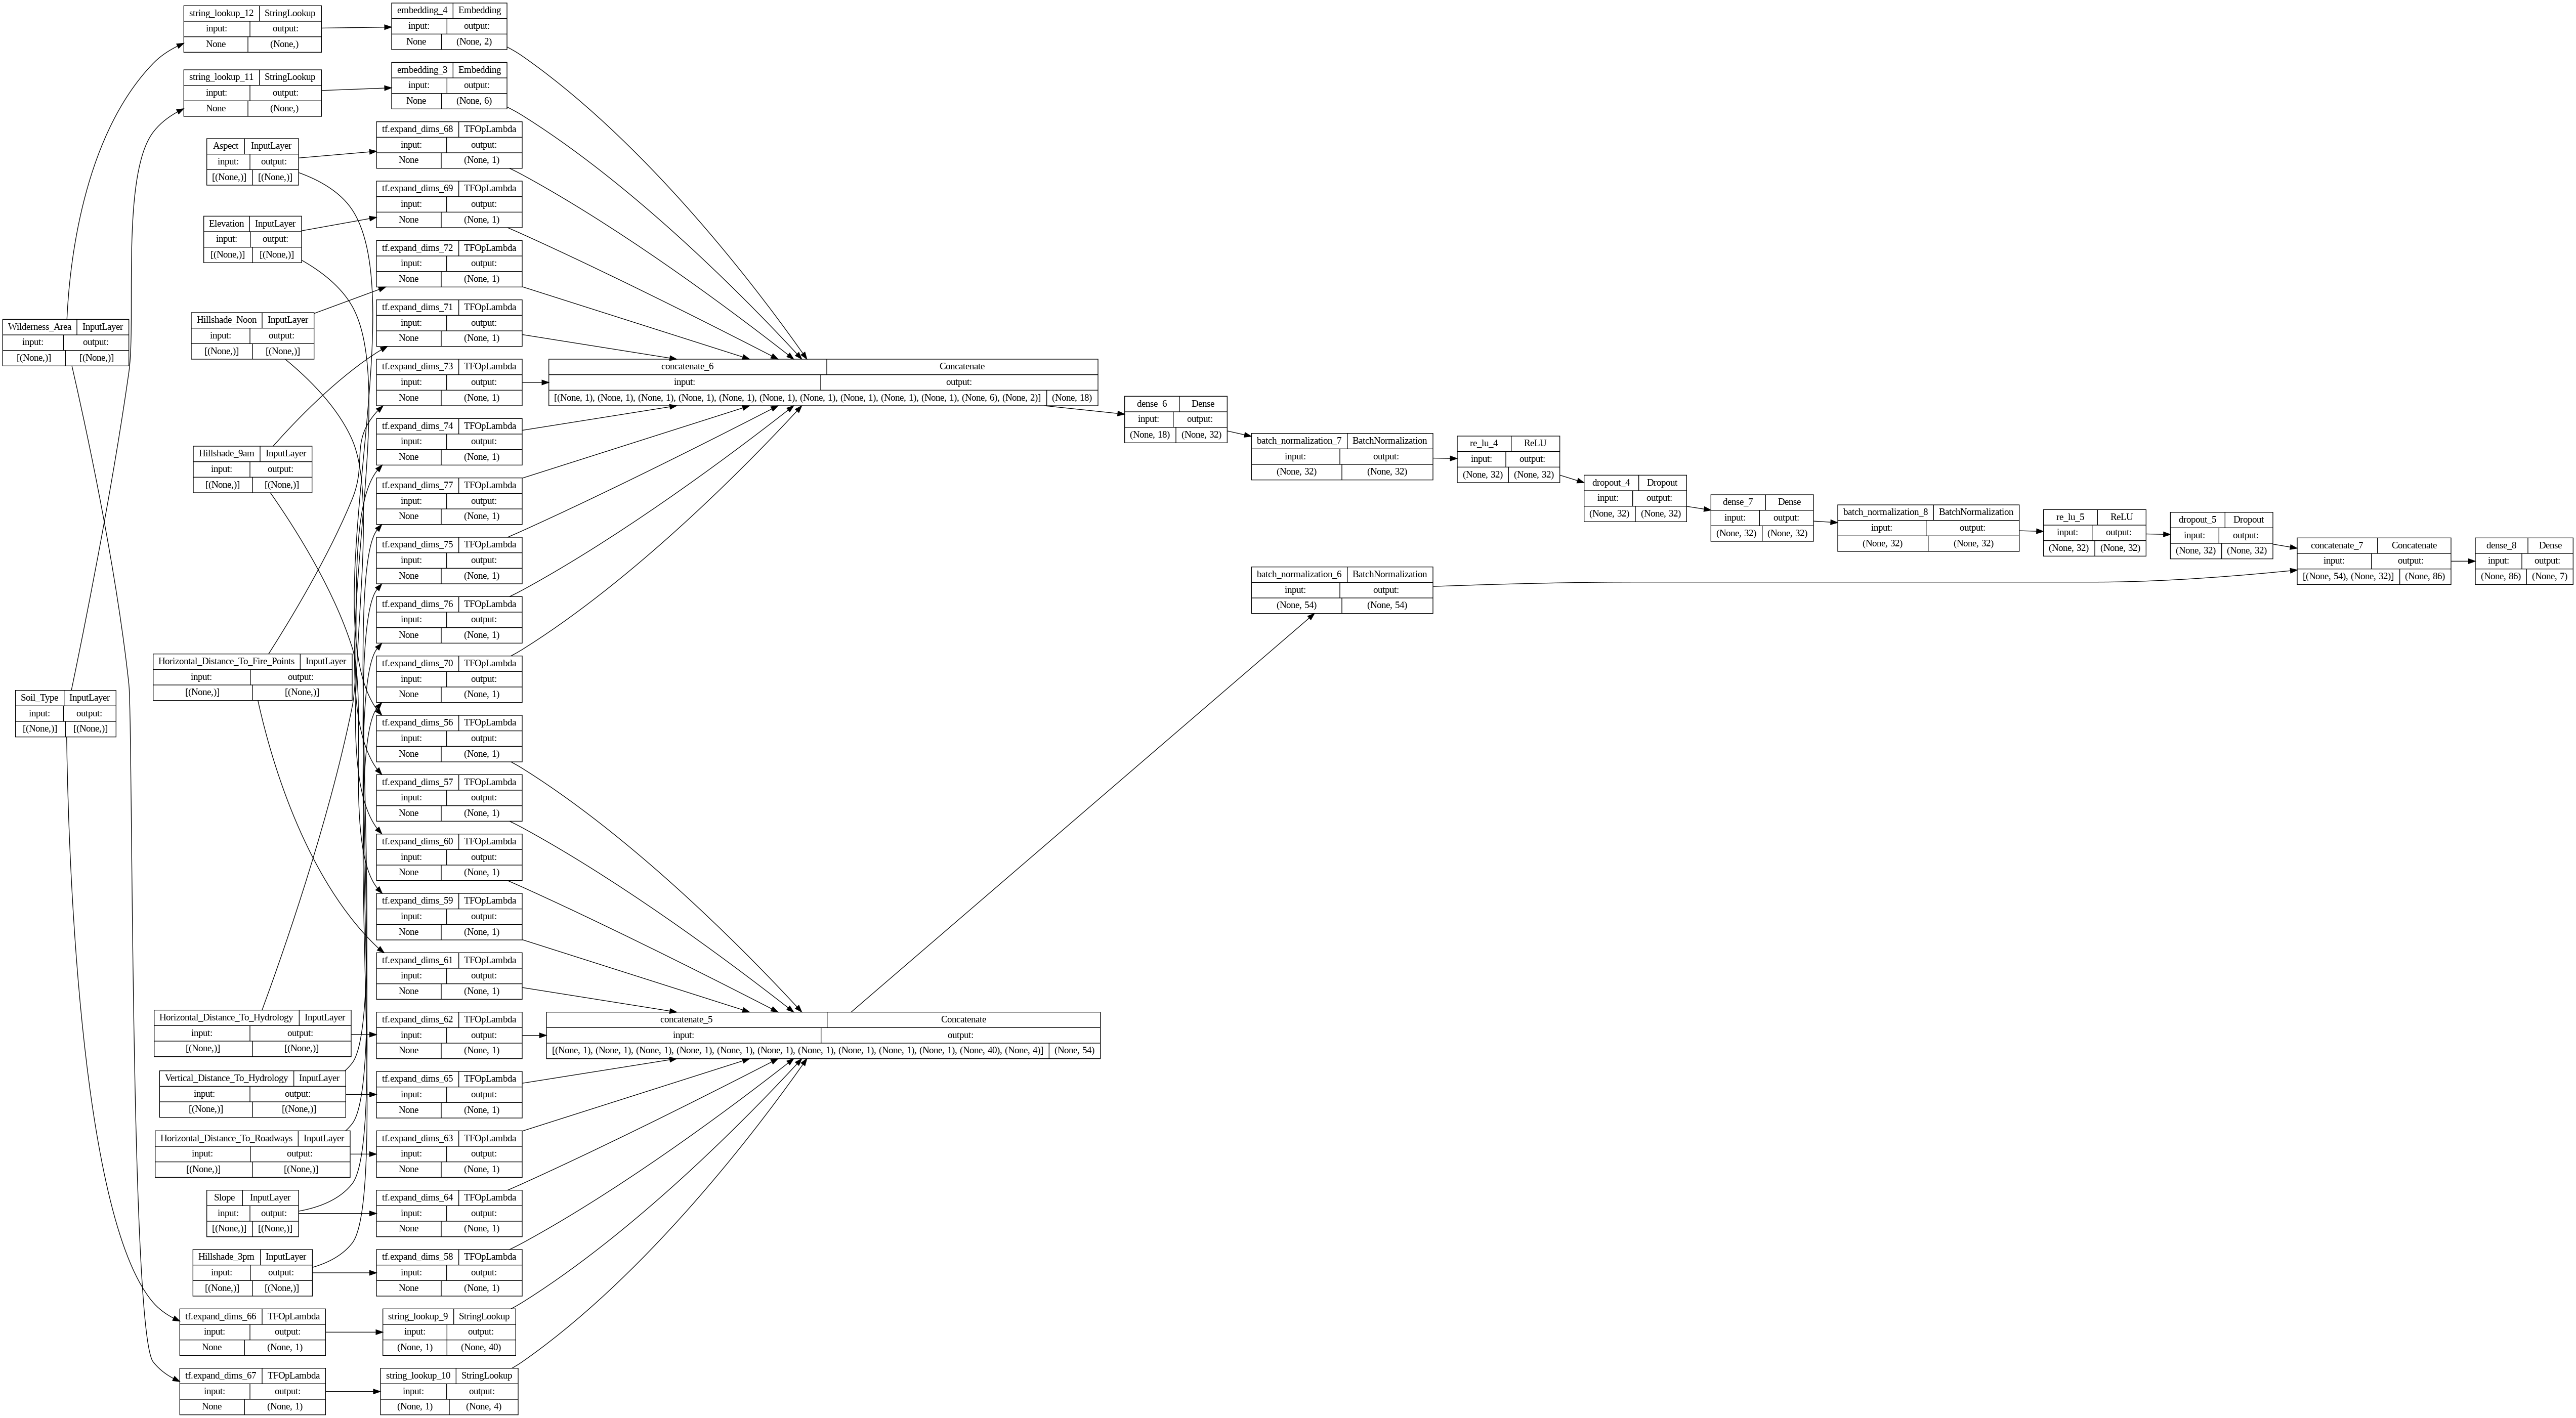

In [ ]:
wide_and_deep_model = create_wide_and_deep_model()

keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir='LR')

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model
Epoch 1/50
1865/1865 [==============================] - 32s 16ms/step - loss: 0.7075 - sparse_categorical_accuracy: 0.7036
Epoch 2/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7370
Epoch 3/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5892 - sparse_categorical_accuracy: 0.7435
Epoch 4/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5780 - sparse_categorical_accuracy: 0.7489
Epoch 5/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5705 - sparse_categorical_accuracy: 0.7529
Epoch 6/50
1865/1865 [==============================] - 12s 7ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.7552
Epoch 7/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5578 - sparse_categorical_accuracy: 0.7582
Epoch 8/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5520 - sparse_categorical_accuracy: 0.7604
Ep

The wide and deep model achieves ~79% test accuracy.

### Deep and Cross Model

The deep part of this model is the same as the deep part created in the wide and deep model experiment. The key idea of the cross part is to apply **explicit feature crossing** in an efficient way, where the degree of cross features grows with layer depth.

In [ ]:
def create_deep_and_cross_model():
  inputs = create_model_inputs()
  x0 = encode_inputs(inputs, use_embedding=True)   # Encoded inputs
  cross = x0   # cross is the encoded feature vector

  for _ in hidden_units:
    units = cross.shape[-1]    # Get number of elements
    x = layers.Dense(units)(cross)
    cross = x0 * x + cross
  cross = layers.BatchNormalization()(cross)

  deep = x0

  for units in hidden_units:
    deep = layers.Dense(units)(deep)
    deep = layers.BatchNormalization()(deep)
    deep = layers.ReLU()(deep)
    deep = layers.Dropout(dropout_rate)(deep)

  merged = layers.concatenate([cross, deep])
  outputs = layers.Dense(units=NUM_CLASSES, activation='softmax')(merged)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


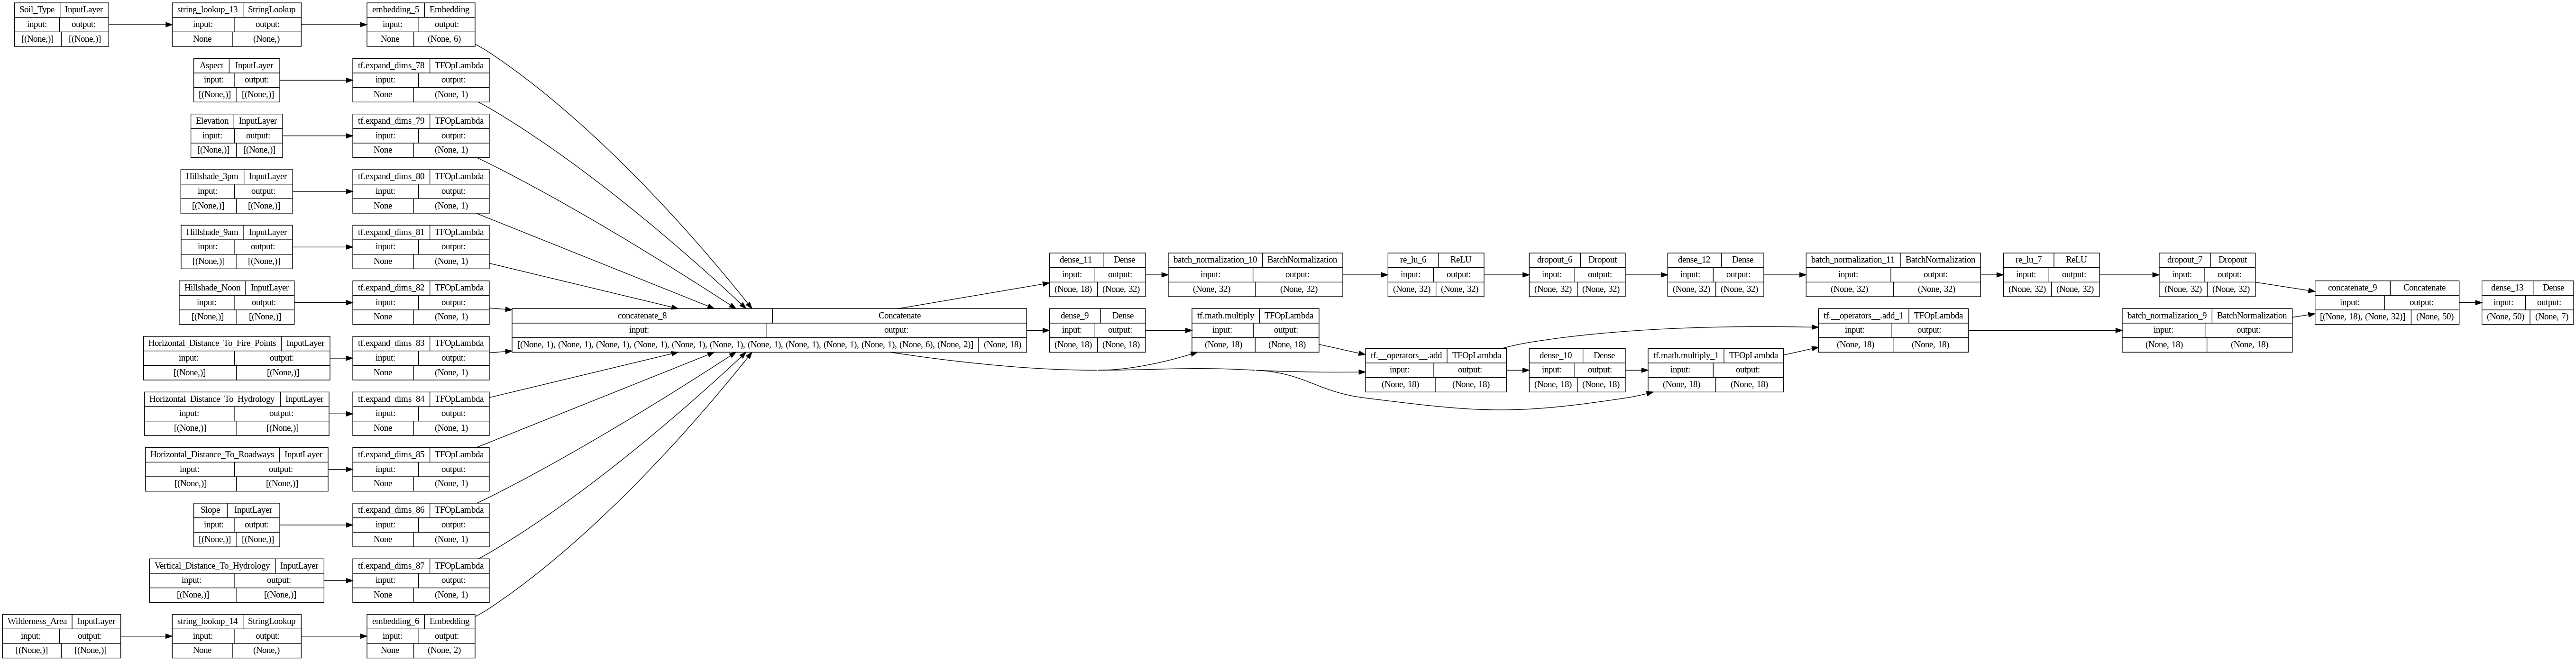

In [ ]:
deep_and_cross_model = create_deep_and_cross_model()

keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir='LR')

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model
Epoch 1/50
1865/1865 [==============================] - 26s 12ms/step - loss: 0.7010 - sparse_categorical_accuracy: 0.7070
Epoch 2/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.5935 - sparse_categorical_accuracy: 0.7442
Epoch 3/50
1865/1865 [==============================] - 9s 5ms/step - loss: 0.5728 - sparse_categorical_accuracy: 0.7511
Epoch 4/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5626 - sparse_categorical_accuracy: 0.7561
Epoch 5/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7586
Epoch 6/50
1865/1865 [==============================] - 10s 5ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.7613
Epoch 7/50
1865/1865 [==============================] - 8s 4ms/step - loss: 0.5453 - sparse_categorical_accuracy: 0.7638
Epoch 8/50
1865/1865 [==============================] - 11s 6ms/step - loss: 0.5420 - sparse_categorical_accuracy: 0.7644
E

### Reference

https://keras.io/examples/structured_data/wide_deep_cross_networks/

Author: Khalid Salama

### Dataset

https://archive.ics.uci.edu/ml/datasets/covertype

https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/